In [113]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import QuantileRegressor

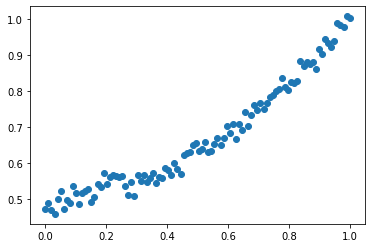

In [114]:
# generate quadratic data
n = 100
x = np.linspace(0, 1, n)
y = 0.5 + 0.5 * x**2 + 0.02 * np.random.randn(n)
X = np.vstack([np.ones_like(x), x, x**2]).T

plt.plot(x, y, 'o')

In [115]:
# define quantile regression model
beta = MX.sym('beta', X.shape[1])
u_pos = MX.sym('u+', x.shape[0])
u_neg = MX.sym('u-', x.shape[0])
theta_pos = MX.sym('theta_pos', X.shape[1])
theta_neg = MX.sym('theta_pos', X.shape[1])
N_rows = x.shape[0]

# lbx = np.zeros(1 + N_rows*2)
# ubx = np.zeros(1 + N_rows*2)
# lbx[0] = -np.inf
# ubx[0] = np.inf
# lbx[1:N_rows+1] = 0
# ubx[1:N_rows+1] = np.inf
# lbx[N_rows+1:] = -np.inf
# ubx[N_rows+1:] = 0
# x0 = np.zeros(1 + N_rows*2)
# x0[0] = 0.1
# x0[1:N_rows+1] = 0.1
# x0[N_rows+1:] = -0.1

x0 = 0
z = vertcat(theta_pos, theta_neg, u_pos, u_neg)
tau = .95
f_obj = 0
g = []
A = DM(np.vstack([X.T, -X.T, np.eye(x.shape[0]), -np.eye(x.shape[0])])).T

g.append(A@z - y)

N_theta = theta_pos.shape[0]
theta_zero = np.zeros((N_theta, x.shape[0]))
c = np.vstack([theta_zero, theta_zero, tau*np.identity(x.shape[0]), (1-tau)*np.identity(x.shape[0])])

f_obj = sum1(c.T @ z)
# for i in range(u_pos.shape[0]):
# f_obj += tau*sum1(fmax(y - X @ beta, 0)) + (1-tau)*sum1(fmax(X@beta - y, 0))
# f_obj = sum1(tau*(fmax(y - mtimes(X, beta), 0)) + (1-tau)*(fmax(mtimes(X, beta) - y, 0)))
# f_obj = tau*sum1(u_pos) + (1-tau)*sum1(u_neg)
# g.append(u_pos - fmax(u_pos, 0))
# g.append(u_neg - fmin(u_neg, 0))
# g.append(X @ beta + u_pos - u_neg - y)


# solve model
prob = {'f': f_obj, 'x': vertcat(theta_pos, theta_neg, u_pos, u_neg), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob)
res = solver(x0=1, lbx=0, ubx=inf, lbg=0, ubg=0)
beta_opt = res['x'][:X.shape[1]] - res['x'][X.shape[1]:2*X.shape[1]]


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    20600
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      206
                     variables with only lower bounds:      206
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+02 1.01e+00 1.43e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [116]:
c.shape


(206, 100)

(100,)

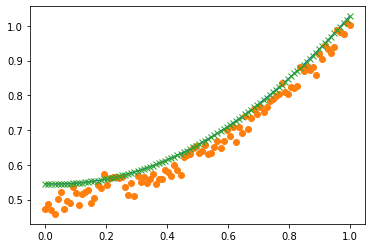

In [123]:

y_opt = (X @ beta_opt).full()
reg = QuantileRegressor(quantile=tau, alpha=0)
reg.fit(X, y)
y_pred = reg.predict(X)
plt.plot(x, y_pred)
plt.plot(x, y, 'o')
plt.plot(x, y_opt, 'x')
x.shape

In [119]:
res['x'][:X.shape[1]] - res['x'][X.shape[1]:2*X.shape[1]]

DM([0.545379, -0.0344287, 0.516417])